In [1]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data"

In [2]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

## Preprocessing

In [3]:
# Separate code into two columns
new_columns = df["CODIGO"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["CODIGO_CLASS"] = new_columns[0]
df["CODIGO_NUM"] = new_columns[1]
df.drop(columns=["CODIGO"], inplace=True)

In [4]:
# FECHAPEDIDO to datetime in day/month/year format
df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)
df.sort_values(by=["FECHAPEDIDO"], inplace=True)
df.reset_index(drop=True, inplace=True)

/var/folders/c6/kf2fcpcj6pq_gwpfbfzzy81m0000gn/T/ipykernel_25769/38037239.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)


In [5]:
# assert all rows in origen follow number-number-number format
def fix_origen_typos(origen_string):
    numbers = re.findall(r"[0-9]+", origen_string)
    return "-".join(numbers)


df["ORIGEN"] = df["ORIGEN"].apply(fix_origen_typos)

In [6]:
# separate ORIGEN in three columns by '-'
origin_separated_columns = df["ORIGEN"].str.split("-", expand=True)
df["PURCHASING_REGION"] = origin_separated_columns[0]
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["ORIGEN"], inplace=True)

In [7]:
# remove /year from NUMERO
# df["NUMERO_PEDIDO"] = df["NUMERO"].str.split("/", expand=True)[0]
# df.drop(columns=["NUMERO"], inplace=True)

In [8]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
# sample random row from dataset
df.sample(1)

,FECHAPEDIDO,NUMERO,REFERENCIA,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,TGL,PRODUCTO,CODIGO_CLASS,CODIGO_NUM,PURCHASING_REGION,PURCHASING_HOSPITAL,PURCHASING_DEPARTMENT
9976,2021-09-13,903907/21,20415,100,50,215.325,430.65,Compra menor,ALMACENABLE,APOSITO DE ESPUMA POLIURETANO / SACRO-11,E,65007,0,10,1


In [61]:
columns = ["FECHAPEDIDO", "TIPOCOMPRA", "CANTIDADCOMPRA"]
sample_df = df[df["PURCHASING_HOSPITAL"] == "10"]
sample_df = sample_df[sample_df["CODIGO_NUM"] == "66071"]
sample_df = sample_df[columns]
sample_df.head()

,FECHAPEDIDO,TIPOCOMPRA,CANTIDADCOMPRA
4,2015-01-05,Compra menor,160
63,2015-01-26,Compra menor,160
107,2015-02-16,Compra menor,160
139,2015-02-27,Compra menor,160
192,2015-03-18,Compra menor,190


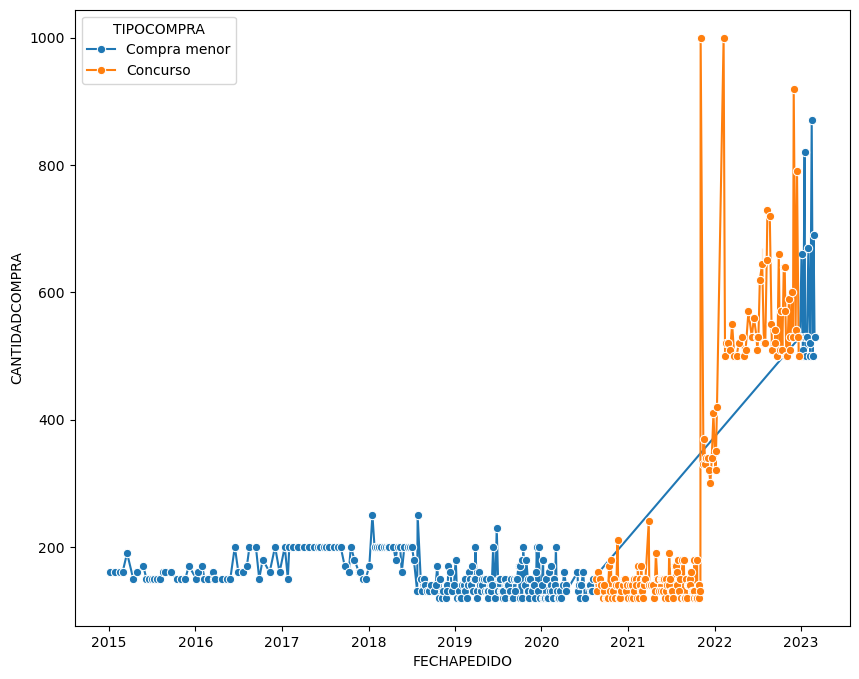

In [62]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    x="FECHAPEDIDO", y="CANTIDADCOMPRA", hue="TIPOCOMPRA", data=sample_df, marker="o"
)
plt.show()

In [63]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["FECHAPEDIDO"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.day / 31)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.dayofyear / 365)
    return df


sample_df = generate_date_features(sample_df)

In [64]:
sample_df = pd.get_dummies(sample_df, columns=["TIPOCOMPRA"], prefix="TIPOCOMPRA")

In [65]:
def add_timeseries_features(df):
    df["ROLLING_MEAN_3M"] = df["CANTIDADCOMPRA"].rolling(90).mean()
    df["WEIGHTED_MEAN_3M"] = (
        df["CANTIDADCOMPRA"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    # df["ROLLING_MEAN_6M"] = df["CANTIDADCOMPRA"].rolling(180).mean()
    # df["WEIGHTED_MEAN_6M"] = (
    #     df["CANTIDADCOMPRA"]
    #     .rolling(180)
    #     .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    # )
    df["ROLLING_MEAN_1Y"] = df["CANTIDADCOMPRA"].rolling(365).mean()
    df["WEIGHTED_MEAN_1Y"] = (
        df["CANTIDADCOMPRA"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    return df


sample_df = add_timeseries_features(sample_df)

In [66]:
sample_df.head()

,FECHAPEDIDO,CANTIDADCOMPRA,YEAR,MONTH,DAYOFMONTH,DAYOFYEAR,TIPOCOMPRA_Compra menor,TIPOCOMPRA_Concurso,ROLLING_MEAN_3M,WEIGHTED_MEAN_3M,ROLLING_MEAN_1Y,WEIGHTED_MEAN_1Y
4,2015-01-05,160,2015,0.500000,0.848644,0.085965,True,False,NaN,NaN,NaN,NaN
63,2015-01-26,160,2015,0.500000,-0.848644,0.432776,True,False,NaN,NaN,NaN,NaN
107,2015-02-16,160,2015,0.866025,-0.101168,0.723644,True,False,NaN,NaN,NaN,NaN
139,2015-02-27,160,2015,0.866025,-0.724793,0.840618,True,False,NaN,NaN,NaN,NaN
192,2015-03-18,190,2015,1.000000,-0.485302,0.970064,True,False,NaN,NaN,NaN,NaN


## Baseline modelling

In [67]:
train = sample_df[sample_df["YEAR"] < 2023]
X_train = train.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
y_train = train["CANTIDADCOMPRA"]

columns_for_plot = X_train.columns.tolist()

test = sample_df[sample_df["YEAR"] == 2023]
X_test = test.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
y_test = test["CANTIDADCOMPRA"]

In [68]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor

# group by year
group_kfold = GroupKFold(n_splits=8)
groups = X_train["YEAR"]

# train model
model = XGBRegressor(random_state=42, n_estimators=500)

val_losses = []
test_losses = []

for idx, (train_index, test_index) in enumerate(
    group_kfold.split(X_train, y_train, groups)
):
    X_train_group, X_val_group = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_group, y_val_group = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_group, y_train_group)

    y_val_pred = model.predict(X_val_group)
    val_loss = mean_squared_error(y_val_group, y_val_pred, squared=False)
    val_losses.append(val_loss)

    y_test_pred = model.predict(X_test)
    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    test_losses.append(test_loss)

    print(
        "FOLD",
        idx,
        "| Val RMSE:",
        val_loss,
        "| Test RMSE:",
        test_loss,
        "| YEARS IN VAL:",
        X_val_group["YEAR"].unique(),
    )

print("MEAN VAL RMSE:", np.mean(val_losses))
print("MEAN TEST RMSE:", np.mean(test_losses))

FOLD 0 | Val RMSE: 158.73537462722194 | Test RMSE: 94.80816452434124 | YEARS IN VAL: [2021]
FOLD 1 | Val RMSE: 29.589682639902932 | Test RMSE: 85.93873404913928 | YEARS IN VAL: [2019]
FOLD 2 | Val RMSE: 25.709146101187418 | Test RMSE: 85.8655331420187 | YEARS IN VAL: [2020]
FOLD 3 | Val RMSE: 193.0476544056434 | Test RMSE: 246.7165889136478 | YEARS IN VAL: [2022]
FOLD 4 | Val RMSE: 166.38477865451648 | Test RMSE: 118.17561574277039 | YEARS IN VAL: [2018]
FOLD 5 | Val RMSE: 31.919881846844998 | Test RMSE: 85.59669541251176 | YEARS IN VAL: [2017]
FOLD 6 | Val RMSE: 35.75116842386201 | Test RMSE: 83.94134967228709 | YEARS IN VAL: [2016]
FOLD 7 | Val RMSE: 25.08401091751774 | Test RMSE: 85.44960473266384 | YEARS IN VAL: [2015]
MEAN VAL RMSE: 83.27771220208712
MEAN TEST RMSE: 110.8115357736725


Baseline model loss (XGBRegressor):
- Trained using GroupKFold with years as groups
- MEAN VAL RMSE: 87.12345687200653
- MEAN TEST RMSE: 104.92861512120264

In [69]:
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
print("FINAL TEST RMSE:", test_loss, "| MAPE:", mape_error)

FINAL TEST RMSE: 83.62435512074963 | MAPE: 0.06702636288142907


FINAL TEST RMSE: 83.62435512074963

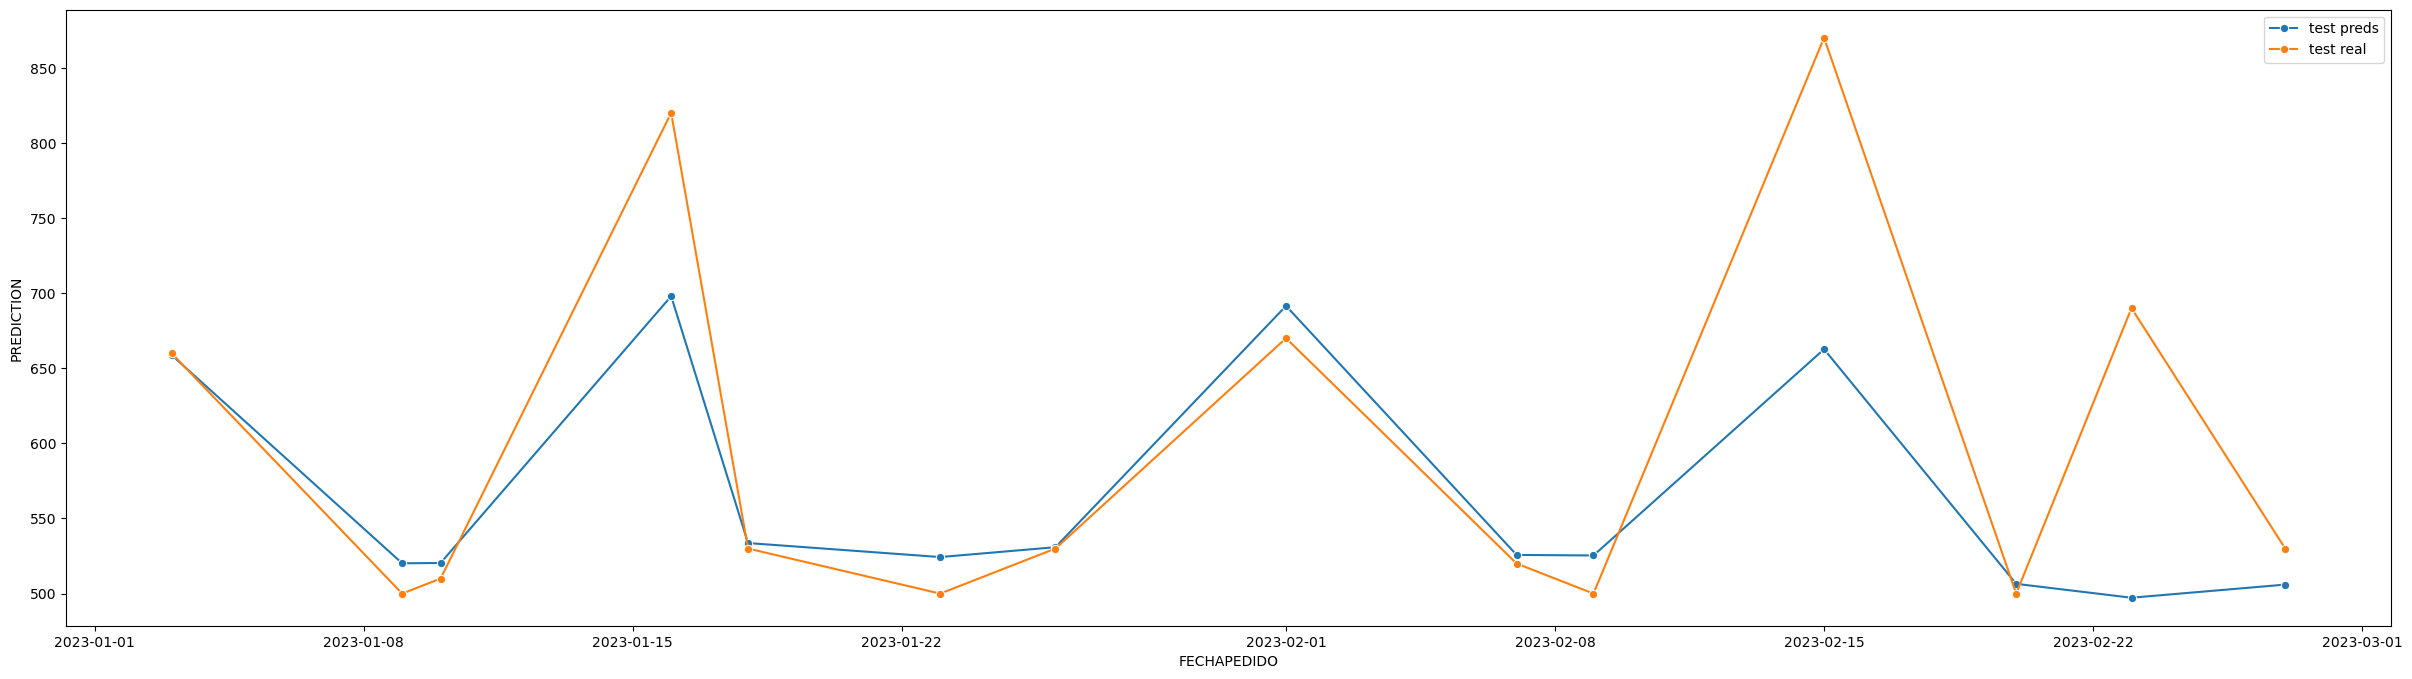

In [70]:
plt.figure(figsize=(30, 8))
X_train["PREDICTION"] = model.predict(X_train)
X_train["REAL"] = y_train
X_train["FECHAPEDIDO"] = train["FECHAPEDIDO"]

X_test["PREDICTION"] = y_test_pred
X_test["REAL"] = y_test
X_test["FECHAPEDIDO"] = test["FECHAPEDIDO"]

# sns.lineplot(
#     x="FECHAPEDIDO", y="PREDICTION", data=X_train, marker="o", label="train preds"
# )
# sns.lineplot(x="FECHAPEDIDO", y="REAL", data=X_train, marker="o", label="train real")
sns.lineplot(
    x="FECHAPEDIDO", y="PREDICTION", data=X_test, marker="o", label="test preds"
)
sns.lineplot(x="FECHAPEDIDO", y="REAL", data=X_test, marker="o", label="test real")
plt.legend()
plt.show()

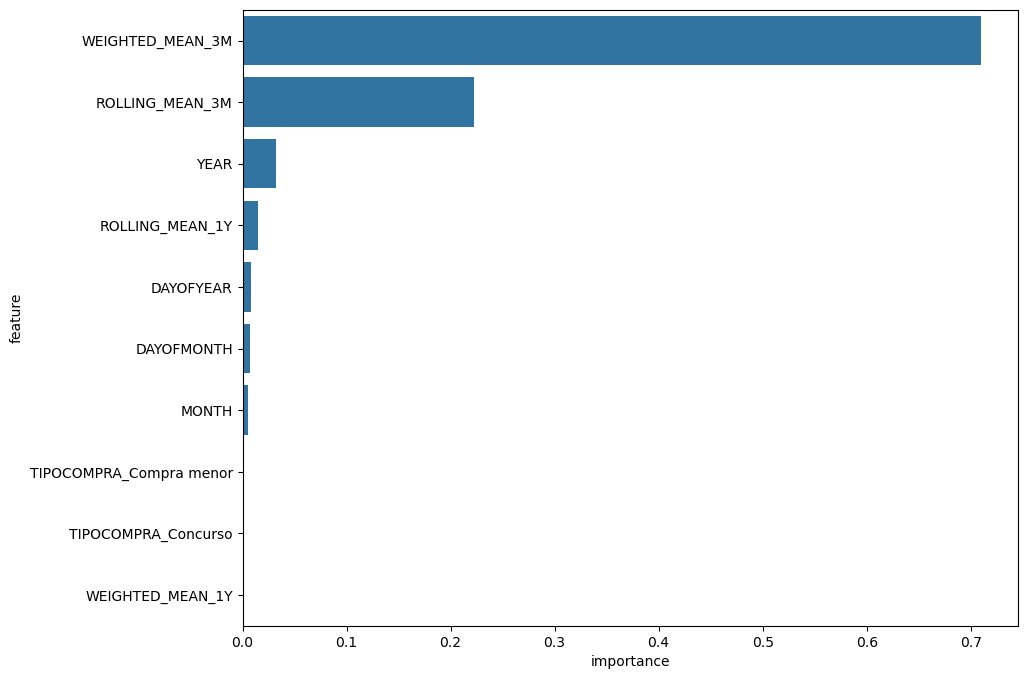

In [71]:
# model feature importance
importances = pd.DataFrame(
    {"feature": columns_for_plot, "importance": model.feature_importances_}
)
importances.sort_values(by="importance", ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=importances)
plt.show()